### Nonlinear Option Pricing (MATHGR5400), Columbia University, Spring 2022
# Homework IV

### Due Date: 11:55 PM Thursday, April 28, 2022
You should turn in the notebook at Columbia CourseWorks website

Please comment your code properly.

Before you turn in the notebook, press the "Run all cells" button in the toolbar, and make sure all the calculation results and graphs are produced correctly in a reasonable time frame, and then save the notebook.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
import warnings 
from scipy.interpolate import interp1d
import pandas as pd
warnings.filterwarnings("ignore")

In [2]:
def blackscholes_price(K, T, S, vol, r=0, q=0, callput='call'):
    """Compute the call/put option price in Black-Scholes model
    
    Parameters
    ----------
    K: scalar or array_like
        The strike of the option.
    T: scalar or array_like
        The maturity of the option.
    S: scalar or array_like
        The spot price of the underlying security.
    vol: scalar or array_like
        The implied Black-Scholes volatility.
    callput: str
        Must be either 'call' or 'put'

    Returns
    -------
    price: scalar or array_like
        The price of the option.

    Examples
    --------
    >>> blackscholes_price(95, 0.25, 100, 0.2, r=0.05, callput='put')
    1.5342604771222823
    """
    F = S*np.exp((r-q)*T)
    w = vol**2*T
    d1 = (np.log(F/K)+0.5*w)/np.sqrt(w)
    d2 = d1 - np.sqrt(w)
    callput = callput.lower()
    if callput == 'call':
        opttype = 1
    elif callput == 'put':
        opttype = -1
    else:
        raise ValueError('The value of callput must be either "call" or "put".')
    price = (opttype*F*norm.cdf(opttype*d1)-opttype*K*norm.cdf(opttype*(d2)))*np.exp(-r*T)
    return price

In [3]:
# all inputs must be scalar
def blackscholes_impv_scalar(K, T, S, value, r=0, q=0, callput='call', tol=1e-6, maxiter=500):
    """Compute implied vol in Black-Scholes model
    
    Parameters
    ----------
    K: scalar
        The strike of the option.
    T: scalar
        The maturity of the option.
    S: scalar
        The spot price of the underlying security.
    value: scalar
        The value of the option
    callput: str
        Must be either 'call' or 'put'

    Returns
    -------
    vol: scalar
        The implied vol of the option.
    """
    if (K <= 0) or (T <= 0):
        return np.nan
    F = S*np.exp((r-q)*T)
    K = K/F
    value = value*np.exp(r*T)/F
    callput = callput.lower()
    if callput not in ['call', 'put']:
        raise ValueError('The value of "callput" must be either "call" or "put"')
    opttype = 1 if callput == 'call' else -1
    value -= max(opttype * (1 - K), 0)
    if value < 0:
        return np.nan
    if (value == 0):
        return 0
    j = 1
    p = np.log(K)
    if K >= 1:
        x0 = np.sqrt(2 * p)
        x1 = x0 - (0.5 - K * norm.cdf(-x0) - value) * np.sqrt(2*np.pi)
        while (abs(x0 - x1) > tol*np.sqrt(T)) and (j < maxiter):
            x0 = x1
            d1 = -p/x1+0.5*x1
            x1 = x1 - (norm.cdf(d1) - K*norm.cdf(d1-x1)-value)*np.sqrt(2*np.pi)*np.exp(0.5*d1**2)
            j += 1
        return x1 / np.sqrt(T)
    else:
        x0 = np.sqrt(-2 * p)
        x1 = x0 - (0.5*K-norm.cdf(-x0)-value)*np.sqrt(2*np.pi)/K
        while (abs(x0-x1) > tol*np.sqrt(T)) and (j < maxiter):
            x0 = x1
            d1 = -p/x1+0.5*x1
            x1 = x1-(K*norm.cdf(x1-d1)-norm.cdf(-d1)-value)*np.sqrt(2*np.pi)*np.exp(0.5*d1**2)
            j += 1
        return x1/np.sqrt(T)

# vectorized version
blackscholes_impv = np.vectorize(blackscholes_impv_scalar, excluded={'callput', 'tol', 'maxiter'})

# Example
blackscholes_impv(K=95, T=0.25, S=100, value=7, callput='call')

array(0.20654803)

In [4]:
def pwlinear_basis(xknots):
    """Basis that represent a piecewise linear function with given knots"""
    fs = [lambda x: np.ones_like(x, dtype=np.float), lambda x: x-xknots[0]]
    fs.extend([lambda x, a=xknots[i]: np.maximum(x-a, 0) for i in range(len(xknots))])
    return fs


def pwlinear_fit(xdata, ydata, xknots):
    """Fit a piecewise linear function with xknots to xdata and ydata"""
    fs = pwlinear_basis(xknots)
    A = np.vstack([f(xdata) for f in fs]).T
    ps = np.linalg.lstsq(A, ydata, rcond=None)[0]
    return ps, fs

def interpol_peicewise(fits,X,t,ts_prev) :
    t_nex  = np.argmax(ts_prev >= t)
    t_prev = t_nex-1    
    w_t = (ts_prev[t_nex] - t)/(ts_prev[t_nex]-ts_prev[t_prev])
    nex_fit  = sum([f(X)*p for (p, f) in zip(fits[t_nex][0],fits[t_nex][1])])
    prev_fit = sum([f(X)*p for (p, f) in zip(fits[t_prev][0],fits[t_prev][1])])
    return w_t*prev_fit + (1-w_t)*nex_fit

def interpol_poly(fits,X,t,ts_prev) :
    t_nex  = np.argmax(ts_prev >= t)
    t_prev = t_nex-1    
    w_t = (ts_prev[t_nex] - t)/(ts_prev[t_nex]-ts_prev[t_prev])
    nex_fit  = np.polyval(fits[t_nex],X)
    prev_fit = np.polyval(fits[t_prev],X)
    return w_t*prev_fit + (1-w_t)*nex_fit


In [19]:
def blackscholes_mc(S=100, vol=0.2, r=0, q=0, ts=np.linspace(0, 1, 13), npaths=10):
    '''generate paths with constant volatility '''
    global W,dW
    nsteps = len(ts) - 1
    ts = np.asfarray(ts)[:, np.newaxis]
    dW = np.random.randn(nsteps, npaths) * np.sqrt(np.diff(ts, axis=0))
    W = np.cumsum(np.vstack((np.zeros((1, npaths), dtype=np.float),dW)),axis=0)  
    paths = np.exp(-0.5*vol**2*ts + vol*W)*S*np.exp((r-q)*ts)
    dW = np.vstack((np.zeros_like(dW[0]),dW))
    return paths

def blackscholes_mc_uv(gamma_fits,S=100, r=0, q=0, ts=np.linspace(0, 1, 13), npaths=10,model='pw_lr'):
    ''' generate paths for uncertain volatility given estimates of gamma'''
    
    ts_prev = np.linspace(0,1,len(gamma_fits))
    nsteps = len(ts) - 1
    ts_ = np.asfarray(ts)[:, np.newaxis]
    np.random.seed(10)
    dW = np.random.randn(nsteps, npaths) * np.sqrt(np.diff(ts_, axis=0))
    W = np.cumsum(np.vstack((np.zeros((1, npaths), dtype=np.float),dW)),axis=0)  
    paths    = np.zeros_like(W)
    paths[0] = paths[0] + S
    dt = 1/(len(ts)-1)
    dW = np.random.randn(nsteps, npaths) * np.sqrt(np.diff(ts_, axis=0))
    interpol_fn = 'interpol_peicewise' if model=='pw_lr' else 'interpol_poly'
    
    for i in range(1,len(ts)) :
        gamma = eval(interpol_fn)(gamma_fits,paths[i-1],ts[i],ts_prev)/(dt*sigma_cap*paths[i-1]) if i!=1 else np.ones_like(paths[0])
        vol = SIGMA(gamma)
        paths[i] = paths[i-1]*np.exp(-0.5*vol**2*dt + vol*dW[i-1])*np.exp((r-q)*dt)
#         paths[i] = paths[i-1] + vol*paths[i-1]*dW[i-1]*np.sqrt(dt)
        

    return paths

<h3 style="color:deepskyblue">Uncertain Volatility Model 1D</h3>

The price of a vanilla payoff $g(X_T)$ on a single asset $X_t$ in the uncertain volatility model satisfies the
one dimensional Black-Scholes-Barenblatt (BSB) PDE
\begin{align*}
\partial_tu(t,x)+\frac{1}{2}x^2\partial_x^2u(t,x)\Sigma\left(\partial_x^2u(t,x)\right)^2&=0\\
u(T,x)&=g(x)
\end{align*}
where
\begin{equation*}
\Sigma(\Gamma)=\left\{\begin{array}\,
\underline{\sigma} & \text{ if }\Gamma<0\\ \overline{\sigma} & \text{ if }\Gamma\geq 0\end{array}\right.
\end{equation*}
For the sake of simplicity, we assume zero interest rate and zero dividend and repo.

The BSB PDE is a fully nonlinear second order parabolic PDE which has a stochastic representation by second-oder BSDE. We are free to choose the diffusion for $X$; we pick a lognormal dynamics with some constant volatility $\hat\sigma$,

$$dX_t=\hat{\sigma} X_tdW_t$$

Two numerical schemes to solve 2-BSDEs are presented below. We first divide $(0, T)$ into $n$ subintervals $(t_{i-1}, t_i)$, $1\leq i\leq n$ and set $\Delta t_i=t_i-t_{i-1}$ and $\Delta W_{t_i} = W_{t_i} - W_{t_{i-1}}$.

<b>Scheme 1</b>
\begin{align*}
Y_{t_n}&=g(X_{t_n})\\
Z_{t_n}&=g'\left(X_{t_n}\right)\\
Y_{t_{i-1}}&=\mathbb{E}_{i-1}\left[Y_{t_i}\right]+\frac{1}{2}\Gamma_{t_{i-1}}X_{t_{i-1}}^2\left(\Sigma\left(\Gamma_{t_{i-1}}\right)^2-\hat{\sigma}^2\right)\Delta t_i\\
Z_{t_{i-1}}&=\frac{1}{\Delta t_i\hat{\sigma} X_{t_{i-1}}}\mathbb{E}_{i-1}\left[Y_{t_i}\Delta W_{t_i}\right]\\
\Gamma_{t_{i-1}}&=\frac{1}{\Delta t_i\hat{\sigma} X_{t_{i-1}}}\mathbb{E}_{i-1}\left[Z_{t_i}\Delta W_{t_i}\right]
\end{align*}

In the second scheme, we introduce explicitly the Malliavin weight for the log-normal diffusion with volatility $\hat{\sigma}$, so that $\Gamma$ can be estimated directly from $Y$ without computing $Z$ in the intermediate step. In particular, there is no need to compute the final condition $Z_{t_n}=g'\left(X_{t_n}\right)$. This could be useful to handle non-smooth payoffs.

<b>Scheme 2</b>
\begin{align*}
Y_{t_n}&=g(X_{t_n})\\
Y_{t_{i-1}}&=\mathbb{E}_{i-1}\left[Y_{t_i}\right]+\frac{1}{2}\Gamma_{t_{i-1}}X_{t_{i-1}}^2\left(\Sigma\left(\Gamma_{t_{i-1}}\right)^2-\hat{\sigma}^2\right)\Delta t_i\\
\Gamma_{t_{i-1}}&=\frac{1}{\left(\Delta t_i\hat{\sigma} X_{t_{i-1}}\right)^2}\mathbb{E}_{i-1}\left[Y_{t_i}\left(\Delta W_{t_i}^2-\Delta t_i\left(1+\hat{\sigma}\Delta W_{t_i}\right)\right)\right]
\end{align*}

-------------------------------------------------------------------------------------------------------------------------------

<b style="color:darkorange">Question 1.</b> Consider pricing the call spread $\frac{100}{K_2-K_1}\left(\left(X_T-K_1\right)^+-\left(X_T-K_2\right)^+\right)$ in the uncertain volatility model, where

\begin{equation*}
\underline{\sigma}=0.1,\quad\overline{\sigma}=0.2,\quad X_0=100,\quad T=1, \quad K_1 = 90, \quad K_2 = 110
\end{equation*}

For your reference, the true price (from PDE) is $56.0$.



In [20]:
## Initialization 

S  = 100
K1 = 90
K2 = 110

sigma_min = 0.1
sigma_max = 0.2
sigma_cap = 0.15
c         = 100/(K2-K1)

delta_fn = lambda x : 0 if (x>K2 or x<K1) else c
delta_fn = np.vectorize(delta_fn)      

payoff   = lambda x : c*(max(x-K1,0) - max(x-K2,0))
payoff   = np.vectorize(payoff)

SIGMA    = lambda x : sigma_min if x<0 else sigma_max 
SIGMA    = np.vectorize(SIGMA)


In [23]:
def UVM_estimates(scheme,n_steps=12,ind_n_steps=360,npaths = 5000,ind_npaths=50000,model='poly',deg=3,n_knots=10) :
    ''' Estimate with uncertainit volatility model
    ------------------------------------------------
    shceme      : Scheme to use
    n_steps     : Number of intervals in non independent simulation 
    ind_n_steps : Number of intervals in independent simulation 
    npaths      : Number of paths to be generated in non independent simulation
    ind_paths   : Number of paths to be generated in independent simulation
    model       : Model to be used in estimation ('poly' or 'pw_lr')
    deg         : Polynomial regression with degree
    n_knots     : Piece wise linear regression with number of knots '''
    
    np.random.seed(1)
    ts     = np.linspace(0,1,n_steps+1)
    ind_ts = np.linspace(0,1,ind_n_steps+1)
    
    paths  = blackscholes_mc(S=S, vol=sigma_cap, r=0, q=0, ts=ts, npaths=npaths)

    gamma  = np.zeros_like(paths[-1])
    Z      = delta_fn(paths[-1])
    Y      = payoff(paths[-1])

    gamma_fits = []
    
    for t in range(len(ts)-2,0,-1) :
        dt = ts[t+1]-ts[t]
        if model == 'poly' :                                     ## If we use polynomical regression estimation
            if scheme == '1' :
                p      = np.polyfit(paths[t], Z*dW[t+1],deg=deg)
                gamma_fits.append(p)
                gamma  = np.polyval(p, paths[t])/(dt*sigma_cap*paths[t])

                p      = np.polyfit(paths[t], Y*dW[t+1],deg=deg)
                Z      = np.polyval(p, paths[t])/(dt*sigma_cap*paths[t])

                p      = np.polyfit(paths[t], Y,deg=deg)
                EY     = np.polyval(p, paths[t])
                Y      = EY + 0.5*(gamma)*(paths[t]**2)*( SIGMA(gamma)**2 - sigma_cap**2 )*dt
                
            if scheme =='2' :
                p      = np.polyfit(paths[t], Y*(dW[t+1]**2 - dt*(1 + sigma_cap*dW[t+1])) ,deg=deg)
                gamma_fits.append(p)
                gamma  = np.polyval(p, paths[t])/((dt*sigma_cap*paths[t])**2)

                p      = np.polyfit(paths[t],Y,deg=deg)
                EY     = np.polyval(p, paths[t])
                Y      = EY + 0.5*(gamma)*(paths[t]**2)*( SIGMA(gamma)**2 - sigma_cap**2 )*dt
                
            if scheme == '2a' :
                p      = np.polyfit(paths[t], Y,deg=deg)
                EY     = np.polyval(p, paths[t])

                p      = np.polyfit(paths[t], (Y-EY)*(dW[t+1]**2 - dt*(1 + sigma_cap*dW[t+1])) ,deg=deg)
                gamma_fits.append(p)
                gamma  = np.polyval(p, paths[t])/((dt*sigma_cap*paths[t])**2)

                Y      = EY + 0.5*(gamma)*(paths[t]**2)*( SIGMA(gamma)**2 - sigma_cap**2 )*dt                
                
        if model == 'pw_lr'  :                                  ## if we use piece-wise linear regression estimation
            xknots  = np.linspace(np.percentile(paths[t], 1), np.percentile(paths[t], 99), n_knots)
            if scheme =='1' :

                ps, fs  = pwlinear_fit(paths[t], Z*dW[t+1], xknots)
                gamma_fits.append((ps,fs))
                gamma   = sum([f(paths[t])*p for (f, p) in zip(fs, ps)])/(dt*sigma_cap*paths[t])

                ps, fs  = pwlinear_fit(paths[t], Y*dW[t+1], xknots)
                Z       = sum([f(paths[t])*p for (f, p) in zip(fs, ps)])/(dt*sigma_cap*paths[t])

                ps, fs  = pwlinear_fit(paths[t], Y, xknots)
                EY      = sum([f(paths[t])*p for (f, p) in zip(fs, ps)])
                Y       = EY + 0.5*gamma*(paths[t]**2)*( SIGMA(gamma)**2 - sigma_cap**2 )*dt
                
            if scheme == '2' :
                ps,fs   = pwlinear_fit(paths[t], Y*(dW[t+1]**2 - dt*(1 + sigma_cap*dW[t+1])) ,xknots)
                gamma_fits.append((ps,fs))
                gamma   = sum([f(paths[t])*p for (f, p) in zip(fs, ps)])/((dt*sigma_cap*paths[t])**2)

                ps,fs   = pwlinear_fit(paths[t],Y,xknots)
                EY      = sum([f(paths[t])*p for (f, p) in zip(fs, ps)])
                Y       = EY + 0.5*(gamma)*(paths[t]**2)*( SIGMA(gamma)**2 - sigma_cap**2 )*dt
                
            if scheme == '2a' :
                ps,fs   = pwlinear_fit(paths[t], Y,xknots)
                EY      = sum([f(paths[t])*p for (f, p) in zip(fs, ps)])

                ps,fs   = pwlinear_fit(paths[t], (Y-EY)*(dW[t+1]**2 - dt*(1 + sigma_cap*dW[t+1])) ,xknots)
                gamma_fits.append((ps,fs))
                gamma   = sum([f(paths[t])*p for (f, p) in zip(fs, ps)])/((dt*sigma_cap*paths[t])**2)

                Y      = EY + 0.5*(gamma)*(paths[t]**2)*( SIGMA(gamma)**2 - sigma_cap**2 )*dt     
                
        
    est = np.round(np.mean(Y),4)

    ## Generating independent paths from above defined function to use fitted gamma values to resimulate paths
    
    gamma_fits = gamma_fits[::-1] 
    gamma_fits.append(gamma_fits[-1])   ## between tn-1 to tn we take fits corresponding to tn-1 because tn are terminal cases                             
    gamma_fits.insert(0,gamma_fits[0])  ## similaring between t0 to t1 we take t1 fits because t0 is just our current condition 

    np.random.seed(10)
    paths = blackscholes_mc_uv(gamma_fits,S=100, r=0, q=0, ts=ind_ts, npaths=50000,model = model)
    ind_est = np.round(np.mean(payoff(paths[-1])),4)
    
    return ind_est,gamma_fits




<b>(a).</b> Implement Scheme 1 with $\hat{\sigma}=0.15$, 12 time steps $(\Delta t_1=1/12)$ and 5000 paths. After you obtain estimates of $x\mapsto\Gamma\left(t_i, x\right)$ at each discretization time $t_i$, re-simulate a new set of independent paths following the process $dX_t = \Sigma(\Gamma(t,X_t))X_tdW_t$ to price the call spread, using more time steps (say, 360 $(\Delta t_2=1/360)$), and more paths (say, 50,000). To evaluate $\Gamma(t,X_t)$ at intermediate time step $t$ with $t_i<t<t_{i+1}$, you may use constant interpolation, i.e. $\Gamma(t_i, X_t)$ or $\Gamma(t_{i+1}, X_t)$, or linear interpolation, i.e., $w_t\Gamma(t_i, X_t)+(1-w_t)\Gamma(t_{i+1},X_t)$ with $w_t=(t_{i+1}-t)/(t_{i+1}-t_i)$. 

<ul>
<li> Experiment with smaller $\Delta t_1$. Comment on the results.
<li> Describe the region where the gamma is positive (resp. negative).
</ul>

In [24]:
time_steps = [12,24,48,96]
results = {'Time Steps':[],'Poly Reg Estimate':[],'Piecewise-Linear Reg Estimate':[]}
for n in time_steps : 
    results['Time Steps'].append(n)
    results['Poly Reg Estimate'].append(UVM_estimates('1',n_steps = n,model='poly')[0])
    results['Piecewise-Linear Reg Estimate'].append(UVM_estimates('1',n_steps = n,model='pw_lr')[0])
    
pd.DataFrame(results)


,Time Steps,Poly Reg Estimate,Piecewise-Linear Reg Estimate
0,12,55.9203,55.8111
1,24,55.0024,54.9304
2,48,52.8910,52.7440
3,96,52.3465,52.1698


In [25]:
ts  = np.linspace(0,1,13)
dt  = 1/(len(ts)-1)
idx = np.where(ts==0.5)[0][0]
x = np.linspace(60,140,100)

poly_fit  = UVM_estimates('1',model='poly')[1][idx]
pw_lr_fit = UVM_estimates('1',model='pw_lr')[1][idx]

fx_1 = np.polyval(poly_fit, x)/(dt*sigma_cap*x)
fx_2 = sum([f(x)*p for (p, f) in zip(pw_lr_fit[0], pw_lr_fit[1])])/(dt*sigma_cap*x)

With polynomial fit gamma is positive uptil  103.6364
With piece-wise linear fit gamma is positive uptil  99.596


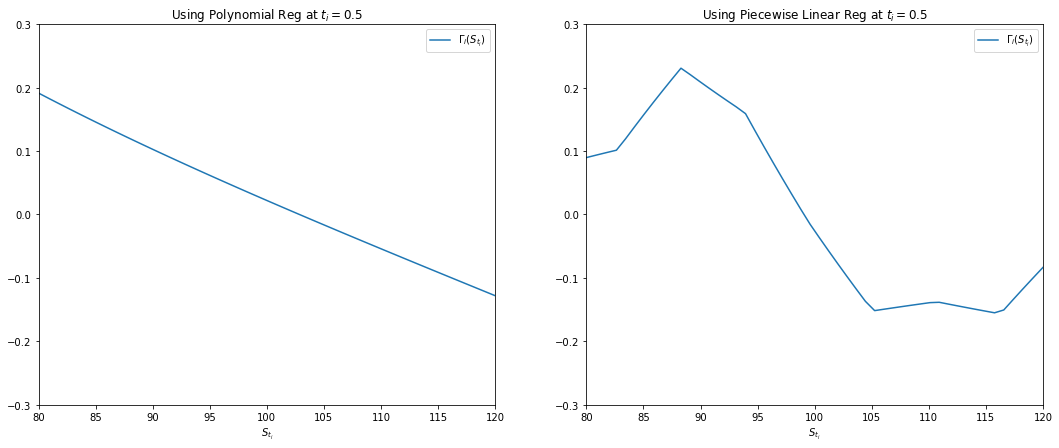

In [26]:
fig, ax = plt.subplots(1,2,figsize=(18,7))
ax[0].set_xlim(left=80, right=120)
ax[0].set_ylim(bottom=-0.3, top=0.3)
ax[0].plot(x, fx_1, label='$\Gamma_{i}(S_{t_{i}})$', )
ax[0].set_xlabel('$S_{t_{i}}$')
ax[0].set_title('Using Polynomial Reg at $t_{i}=0.5$')
ax[0].legend(loc=0)

ax[1].set_xlim(left=80, right=120)
ax[1].set_ylim(bottom=-0.3, top=0.3)
ax[1].plot(x, fx_2, label='$\Gamma_{i}(S_{t_{i}})$', )
ax[1].set_xlabel('$S_{t_{i}}$')
ax[1].set_title('Using Piecewise Linear Reg at $t_{i}=0.5$')
ax[1].legend(loc=0)

a1 = sorted([(i,j) for (i,j) in zip(x,fx_1)],key = lambda x: x[0])
a2 = sorted([(i,j) for (i,j) in zip(x,fx_2)],key = lambda x: x[0]) 
thresh1 =  a1[np.argmax(np.array([i[1] for i in a1]) < 0)][0]
thresh2 =  a2[np.argmax(np.array([i[1] for i in a2]) < 0)][0]


print("With polynomial fit gamma is positive uptil ",np.round(thresh1,4))
print("With piece-wise linear fit gamma is positive uptil ",np.round(thresh2,4))

-----------------------------------------------------------------------------------------------------------------------------

<b>(b).</b> Implement Scheme 2 outlined above to price the call spread. As in part (a), after you obtain estimates of $x\mapsto\Gamma\left(t_i, x\right)$ at each discretization time $t_i$, re-simulate a new set of independent paths following the process $dX_t = \Sigma(\Gamma(t,X_t))X_tdW_t$ to price the call spread, using more time steps. Compare the results of the two schemes.


<b>Scheme 2</b>
\begin{align*}
Y_{t_n}&=g(X_{t_n})\\
Y_{t_{i-1}}&=\mathbb{E}_{i-1}\left[Y_{t_i}\right]+\frac{1}{2}\Gamma_{t_{i-1}}X_{t_{i-1}}^2\left(\Sigma\left(\Gamma_{t_{i-1}}\right)^2-\hat{\sigma}^2\right)\Delta t_i\\
\Gamma_{t_{i-1}}&=\frac{1}{\left(\Delta t_i\hat{\sigma} X_{t_{i-1}}\right)^2}\mathbb{E}_{i-1}\left[Y_{t_i}\left(\Delta W_{t_i}^2-\Delta t_i\left(1+\hat{\sigma}\Delta W_{t_i}\right)\right)\right]
\end{align*}

In [27]:
results = {'Scheme':[],'Poly Reg Estimate':[],'Piecewise-Linear Reg Estimate':[]}
for scheme in ['1','2'] : 
    results['Scheme'].append(scheme)
    results['Poly Reg Estimate'].append(UVM_estimates(scheme,model='poly')[0])
    results['Piecewise-Linear Reg Estimate'].append(UVM_estimates(scheme,model='pw_lr')[0])
    
pd.DataFrame(results)

,Scheme,Poly Reg Estimate,Piecewise-Linear Reg Estimate
0,1,55.9203,55.8111
1,2,51.6996,53.5517


We observe that estimation from scheme2 doesnt give us better reuslts as compared to the scheme 1 

------------------------------------------------------------------------------------------------------------------------------

<b>(c).</b> In schemes 1 and 2, the estimations of the conditional expectations for $Z_{t_{i-1}}$ and $\Gamma_{t_{i-1}}$ may suffer large variances when $\Delta t_i$ is small. Control variates can be used to reduce the variance. For example, Scheme 2 can be modified as follows

<b>Scheme 2a</b>
\begin{align*}
Y_{t_n}&=g(X_{t_n})\\
Y_{t_{i-1}}&=\mathbb{E}_{i-1}\left[Y_{t_i}\right]+\frac{1}{2}\Gamma_{t_{i-1}}X_{t_{i-1}}^2\left(\Sigma\left(\Gamma_{t_{i-1}}\right)^2-\hat{\sigma}^2\right)\Delta t_i\\
\Gamma_{t_{i-1}}&=\frac{1}{\left(\Delta t_i\hat{\sigma} X_{t_{i-1}}\right)^2}\mathbb{E}_{i-1}\left[\left(Y_{t_i}-\mathbb{E}_{i-1}\left[Y_{t_i}\right]\right)\left(\Delta W_{t_i}^2-\Delta t_i\left(1+\hat{\sigma}\Delta W_{t_i}\right)\right)\right]
\end{align*}
Note that $Y_{t_i}$ on the right side of the last equation has been replaced by $Y_{t_{i}}-\mathbb{E}_{i-1}\left[Y_{t_i}\right]$.

Explain why this replacement does not change the left hand side. Implement Scheme 2a. Do you observe variance reduction?

In [29]:
time_steps = [12,24,48]
results = {'Time Steps':[],'Scheme':[],'Poly Reg Estimate':[],'Piecewise-Linear Reg Estimate':[]}

for n in time_steps : 
    for scheme in ['2','2a'] : 
        results['Time Steps'].append(n)
        results['Scheme'].append(scheme)
        results['Poly Reg Estimate'].append(UVM_estimates(scheme,n_steps=n,model='poly')[0])
        results['Piecewise-Linear Reg Estimate'].append(UVM_estimates(scheme,n_steps=n,model='pw_lr')[0])
    
pd.DataFrame(results)

,Time Steps,Scheme,Poly Reg Estimate,Piecewise-Linear Reg Estimate
0,12,2,51.6996,53.5517
1,12,2a,55.5078,55.1840
2,24,2,52.3157,52.5846
3,24,2a,54.4577,55.0812
4,48,2,48.3353,49.5329
5,48,2a,52.9335,54.6180


We observe that as time interval decrease the results from scheme2 deteriorates while we still keep getting better results from scheme 2a. This is because we have used variance reduction using control variate. So even though dt reduces we get stable results from scheme 2a

Explain why this replacement does not change the left hand side. Implement Scheme 2a. Do you observe variance reduction?
<br><br><br>
We have the following :  

$\mathbb{E}_{i-1}\left[\mathbb{E}_{i-1}\left[Y_{t_i}\right]\left(\Delta W_{t_i}^2-\Delta t_i\left(1+\hat{\sigma}\Delta W_{t_i}\right)\right)\right] = \mathbb{E}_{i-1}\left[Y_{t_i}\right] \times \mathbb{E}_{i-1} \left[\left(\Delta W_{t_i}^2-\Delta t_i\left(1+\hat{\sigma}\Delta W_{t_i}\right)\right)\right]$.

$\implies \mathbb{E}_{i-1}\left[\left(Y_{t_i}-\mathbb{E}_{i-1}\left[Y_{t_i}\right]\right)\left(\Delta W_{t_i}^2-\Delta t_i\left(1+\hat{\sigma}\Delta W_{t_i}\right)\right)\right] = \mathbb{E}_{i-1}\left[Y_{t_i}\left(\Delta W_{t_i}^2-\Delta t_i\left(1+\hat{\sigma}\Delta W_{t_i}\right)\right)\right] - \mathbb{E}_{i-1}\left[Y_{t_i}\right] \times \mathbb{E}_{i-1} \left[\left(\Delta W_{t_i}^2-\Delta t_i\left(1+\hat{\sigma}\Delta W_{t_i}\right)\right)\right]$ 

<br>

We also have,
\begin{align*}
\mathbb{E}_{i-1} \left[\left(\Delta W_{t_i}^2-\Delta t_i\left(1+\hat{\sigma}\Delta W_{t_i}\right)\right)\right] &= \mathbb{E}_{i-1} \left[\Delta W_{t_i}^2 \right] - \Delta t_i \times \mathbb{E}_{i-1} \left[1+\hat{\sigma}\Delta W_{t_i}\right] \\
&= \Delta t_i - \Delta t_i \times (1+0) \\
&=0
\end{align*}

Thus, 
$\mathbb{E}_{i-1}\left[\left(Y_{t_i}-\mathbb{E}_{i-1}\left[Y_{t_i}\right]\right)\left(\Delta W_{t_i}^2-\Delta t_i\left(1+\hat{\sigma}\Delta W_{t_i}\right)\right)\right] = \mathbb{E}_{i-1}\left[Y_{t_i}\left(\Delta W_{t_i}^2-\Delta t_i\left(1+\hat{\sigma}\Delta W_{t_i}\right)\right)\right]$

Thus, the left hand size does not change.

-------------------------------------------------------------------------------------------------------------------------------

<h3 style="color:deepskyblue">The particle Method and Smile Calibration</h3>

<b style="color:darkorange">Question 2.</b> Consider the stochastic local volatility (SLV) model

$$
\begin{array}{l}
dS_t = a_t l(t, S_t) S_t dW^{(1)}_t\\
a_t=\sigma_0 e^{Y_t}\quad\text{where}\quad d Y_t = -\kappa Y_tdt+\gamma dW^{(2)}_t\\
d \langle W^{(1)}, W^{(2)} \rangle_t = \rho dt.
\end{array}
$$

The numerical values for the model parameters are
- $T = 1$.
- $S_0 = 100$.
- $\sigma_0 = 15\%$.
- $Y_0 = 0$.
- $\rho = -50\%$.
- $\gamma = 50\%$.
- $\kappa = 1$.

The goal is to find a leverage function $l(t, S)$ so that this model matches the market prices of vanilla options. For the sake of simplicity, we assume that the market implied volatility surface is flat $\sigma_{\textrm{Market}} \equiv 15\%$. In that case, we also have $\sigma_{\textrm{Dup}}(t,S) \equiv 15\%$.

In [40]:
T = 1
S0 = 100
sigma_0 =0.15
sigma0 =0.15
rho = -0.5 
gamma = 0.5 
kappa = 1
sigma_mkt = 0.15
Y0 = 0
ts = np.linspace(0,1,101)
dt = 1/(len(ts)-1)
npaths   = 10000
indPaths = 100000
bw_param = 1
knots = 50

Below we describe a Monte Carlo simulation scheme for the SLV model.

First we discretize the interval $(0,T)$ into subintervals $(t_{i-1}, t_i)$, $1\leq i\leq n$, and set $\Delta t_i=t_i-t_{i-1}$. 

The Ornstein-Uhlenbeck process $Y$ is explicitly solvable:
\begin{equation}
Y_{t_i}=e^{-\kappa\Delta t_i}Y_{t_{i-1}}+\int_{t_{i-1}}^{t_i}\gamma e^{-\kappa\left(t_i-s\right)}dW_s^{(2)}.
\end{equation}

Therefore for given $Y_{t_{i-1}}$, $Y_{t_i}$ is a Gaussian variable with 
\begin{equation}\tag{1}
\mathbb{E}\left[\left.Y_{t_i}\right\vert Y_{t_{i-1}}\right]=e^{-\kappa\Delta t_i}Y_{t_{i-1}},\quad
\text{var}\left[\left.Y_{t_i}\right\vert Y_{t_{i-1}}\right]=\frac{\gamma^2}{2\kappa}\left(1-e^{-2\kappa\Delta t_i}\right)
\end{equation}

so that paths of $Y$ can be simulated exactly.

To simualte the spot process $S$, we use the Euler scheme:
$$\log S_{t_i}-\log S_{t_{i-1}}=-\frac{1}{2}\sigma_0^2e^{2Y_{t_{i-1}}}l(t_{i-1},S_{t_{i-1}})^2\Delta t_i+\sigma_0 e^{Y_{t_{i-1}}}l(t_{i-1},S_{t_{i-1}})\int_{t_{i-1}}^{t_i}dW^{(1)}_t$$

Thus for given $S_{t_{i-1}}$ and $Y_{t_{i-1}}$, $\log S_{t_i}$ and $Y_{t_i}$ are jointly Gaussian variables with

\begin{equation}\tag{2}
\mathbb{E}\left[\left.\log S_{t_i}\right\vert S_{t_{i-1}},Y_{t_{i-1}}\right]=\log S_{t_{i-1}}-\frac{1}{2}\sigma_0^2e^{2Y_{t_{i-1}}}\Delta t_i,\quad\text{Var}\left[\left.\log S_{t_i}\right\vert S_{i_{i-1}}, Y_{t_{i-1}}\right]=\sigma_0^2e^{2Y_{t_{i-1}}}l(t_{i-1},S_{t_{i-1}})^2\Delta t_i
\end{equation}

\begin{equation}\tag{3}
\text{Cov}\left[\left.Y_{t_i},\log S_{t_i}\right\vert S_{t_{i-1}}, Y_{t_{i-1}}\right]=\sigma_0 e^{Y_{t_{i-1}}}l(t_{i-1},S_{t_{i-1}})\frac{\gamma\rho}{\kappa}\left(1-e^{-\kappa\Delta t_i}\right)
\quad\text{or}\quad
\text{Corr}\left[\left.Y_{t_i},\log S_{t_i}\right\vert S_{t_{i-1}}, Y_{t_{i-1}}\right]=\rho\sqrt{\frac{2(1-e^{-\kappa\Delta t_i})}{\kappa\Delta t_i(1+e^{-\kappa\Delta t_i})}}
\end{equation}

Over the time interval $[t_{i-1}, t_i]$, we can advance $\log S$ and $Y$ by generating Gaussian variables $\log S_{t_i}$ and $Y_{t_i}$ using equations (1)-(3). That is,

\begin{align}
\log S_{t_i} &= \log S_{t_{i-1}}-\frac{1}{2}\sigma_0^2e^{2Y_{t_{i-1}}}l(t_{i-1},S_{t_{i-1}})^2\Delta t_i+\sigma_0e^{Y_{t_{i-1}}}l(t_{i-1},S_{t_{i-1}})\sqrt{\Delta t_i}\left(\sqrt{1-\bar{\rho}^2}Z_1+\bar{\rho}Z_2\right),\quad\text{where }\bar{\rho}=\rho\sqrt{\frac{2(1-e^{-\kappa\Delta t_i})}{\kappa\Delta t_i(1+e^{-\kappa\Delta t_i})}}\\
Y_{t_i} &= e^{-\kappa\Delta t_i}Y_{t_{i-1}}+\gamma\sqrt{\frac{1-e^{-2\kappa\Delta t_i}}{2\kappa}}Z_2
\end{align}
where $Z_1$ and $Z_2$ are independent standard normal variables.

In [41]:
def quartic_kernel(x):
    x = np.clip(x, -1, 1)
    return (x+1)**2*(1-x)**2  

def kern_reg(x, xdata, ydata, bandwidth, kern=quartic_kernel):
    weights = kern((xdata[:, np.newaxis] - x) / bandwidth)
    return np.sum(weights * ydata[:, np.newaxis], axis=0) / np.sum(weights, axis=0) 

# bw = lambda t : bw_param*sigma_m*S0*np.sqrt(max(t,0.15))*pow(npaths,-0.2)
bw = lambda x : bw_param*sigma_m*S0*pow(npaths,-0.2)*np.sqrt(max(0.15, x))
rho_bar = lambda rho : rho*np.sqrt((2*(1-np.exp(-kappa*dt)))/(kappa*dt*(1+np.exp(-kappa*dt))))

def generate_paths(gamma=0.5,localVol_present=True,rho = -0.5,kappa=kappa,ts=ts ) :
    
    ## Intitalization ##
    Y = np.zeros((len(ts),npaths))+ Y0
    S = np.zeros_like(Y) + S0
    a = sigma0*np.exp(Y)
    loc_vol = np.ones_like(Y)    
    fits = []
    Z1,Z2 = np.random.randn(len(ts), npaths), np.random.randn(len(ts), npaths)
    dt = ts[1]-ts[0]
    
    np.random.seed(1)
    Z1 = np.random.randn(len(ts),npaths)
    np.random.seed(2) 
    Z2 = np.random.randn(len(ts),npaths)
    
    # Path Generation #
    for t in range(1, len(ts)):
        Y[t] = np.exp(-kappa*dt)*Y[t-1] + gamma*np.sqrt((1-np.exp(-2*kappa*dt))/(2*kappa))*Z2[t] 
        a[t] = sigma0*np.exp(Y[t])
        S[t] = S[t-1]*np.exp(-0.5*(sigma0**2)*np.exp(2*Y[t-1])*(loc_vol[t-1]**2)*dt + sigma0*np.exp(Y[t-1])*loc_vol[t-1]*np.sqrt(dt)*(np.sqrt(1-rho_bar(rho)**2)*Z1[t]+rho_bar(rho)*Z2[t]))
        x_knots = np.linspace(np.percentile(S[t], 1), np.percentile(S[t], 99), knots)
        y_knots = np.sqrt(kern_reg(x_knots,S[t],a[t]**2,bw(ts[t])))
        fits.append(lambda x: sigma_mkt / interp1d(x_knots, y_knots, kind='cubic', fill_value='extrapolate')(x))
        loc_vol[t] = fits[t-1](S[t]) if localVol_present else loc_vol[t]
        
        
    # Carrying out independent simulation 
    Y = np.zeros((len(ts),npaths))+ Y0
    S = np.zeros_like(Y) + S0
    loc_vol = np.ones_like(Y)    
    Z1,Z2 = np.random.randn(len(ts), npaths), np.random.randn(len(ts), npaths)
    
    for t in range(1,len(ts)) :
        Y[t] = np.exp(-kappa*dt)*Y[t-1] + gamma*np.sqrt((1-np.exp(-2*kappa*dt))/(2*kappa))*Z2[t] 
        S[t] = S[t-1]*np.exp(-0.5*(sigma0**2)*np.exp(2*Y[t-1])*(loc_vol[t-1]**2)*dt + sigma0*np.exp(Y[t-1])*loc_vol[t-1]*np.sqrt(dt)*(np.sqrt(1-rho_bar(rho)**2)*Z1[t]+rho_bar(rho)*Z2[t]))
        loc_vol[t] = fits[t-1](S[t]) if localVol_present else loc_vol[t]
        
    return fits,S

<b>(a).</b> Implementation of the Particle Method.
- Implement the particle method studied in class to find the leverage function $l$. For this purpose, you may use the zero-th order non-parametric regression routine provided in the first assignment. We suggest that you use the quartic kernel

$$K(x)=(x+1)^2(1-x)^2\quad\text{for }-1\leq x\leq 1\quad\text{and}\quad0\quad\text{ elsewhere}$$

together with the bandwidth 

$$h = \kappa \sigma_{\mathrm{Market}} S_0 \sqrt{\max(t_k,0.15)}N^{-0.2}$$

at discretization date $t_k$. Make sure to fine-tune the dimensionless bandwidth parameter $\kappa$. Its order of magnitude is 1.0. Use $\Delta t = 1/100$, $N=10,000$ paths. Note: In class, we described an acceleration technique that involves sorting the "particles" $(S_{t_k},a_{t_k})$ according to the spot value $S_{t_k}$. Since the kernel we have chosen has compact support and is fairly inexpensive to evaluate, you may ignore this acceleration technique here. This means that each estimation of a conditional expectation $\mathbb{E}\left[\left.a_{t_k}^2\right\vert S_{t_k}=x\right]$ (for $x$ in a grid of spot values) involves the ratio of two sums of $N$ terms each.

- Check that the resulting model is indeed calibrated to the market implied volatilities $\sigma_{\textrm{Market}} \equiv 15\%$. To this end, compute estimates of the call prices (maturity $T=1$) in the calibrated model for strikes $70, 80, 90, 100, 110, 120, 130, 140$, and invert the Black-Scholes formula to get the corresponding estimation of the implied volatilities $\hat\sigma(T,K)$. To estimate the call prices in the calibrated model, simulate a new set of independent paths with the calibrated leverage function $l$ and $N_2 = 100,000$ paths. For the inversion of the Black-Scholes formula, you can use the function <code>blackscholes_impv</code> provided below.


In [42]:
fits,S = generate_paths() 
strikes = [70,80,90,100,110,120,130,140]
strike_dict = {}

for K in strikes :
    payoff_fn = np.vectorize(lambda x : max(x-K,0))
    C = (np.mean(payoff_fn(S[-1])))
    impVol =  blackscholes_impv(K, T=1, S=100, value=C, callput='call') 
    strike_dict[K] = {'CallPrice':np.round(C,5),'ImpliedVol':np.round(impVol,5)}

pd.DataFrame(strike_dict).T

,CallPrice,ImpliedVol
70,30.12433,0.17790
80,20.48194,0.15636
90,12.03508,0.15045
100,5.74100,0.14403
110,2.38940,0.14673
120,0.84860,0.14793
130,0.26150,0.14843
140,0.08000,0.15091


We observe that our model is indeed calibrated to market implied volatility of 0.15

<b>(b).</b> Fix the spot-vol correlation $\rho = 0\%$ and mean reversion $\kappa=1$. We study the impact of volatility of volatility $\gamma$ on the smile in the pure stochastic volatility model and calibrated leverage function in the SLV model. Perform the following tasks with various values of $\gamma$. Suggested values of $\gamma$: $0\%$, $25\%$, $50\%$, $75\%$.
- Recalibrate the leverage function $l(t,S)$ for each $\gamma$, and plot the calibrated leverage function $l(t, S)$ as a function of the spot value $S$ for a fixed maturity, e.g., $t = T$ with various values of $\gamma$ in the same graph. Comment on the dependence of the shape of the leverage function on $\gamma$.
- Plot the corresponding smile at maturity $T$ for the pure stochastic volatility model (set the leverage function $l \equiv 1$) with the various values of $\gamma$ in the same graph. Comment on the dependence of the shape of the smile on $\gamma$.

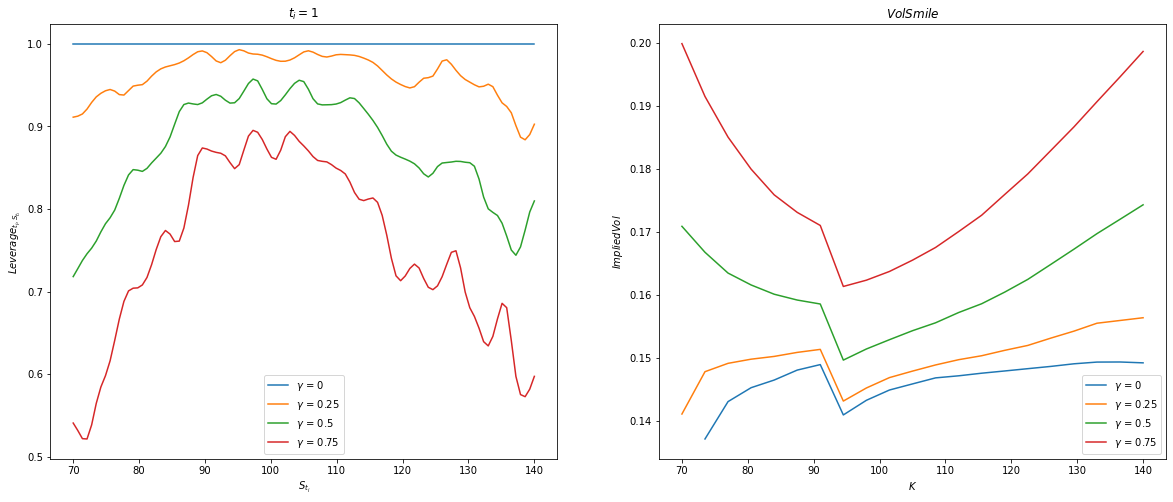

In [43]:
rho = 0
kappa = 1
gamma_values = [0,0.25,0.5,0.75]
spot_values = np.linspace(70,140,101)
fig, ax = plt.subplots(1,2,figsize=(20, 8))

for gamma in gamma_values :
    fits,S = generate_paths(gamma=gamma,kappa=kappa,rho=rho) 
    ax[0].plot(spot_values, fits[-1](spot_values), label='$\gamma$ = '+str(gamma))

ax[0].set_xlabel('$S_{t_{i}}$')
ax[0].set_ylabel('$Leverage_{t_{i},S_{t_{i}}}$')
ax[0].set_title('$t_{i}=1$')
ax[0].legend(loc=0)

for gamma in gamma_values :
    fits,S = generate_paths(gamma=gamma,kappa=kappa,rho=rho,localVol_present=False) 
    impVol = []
    strikes = np.linspace(70,140,21) 
    for K in strikes :
        payoff_fn = np.vectorize(lambda x : max(x-K,0))
        C = (np.mean(payoff_fn(S[-1])))
        impVol.append(blackscholes_impv(K, T=1, S=100, value=C, callput='call'))
    ax[1].plot(strikes,impVol,label='$\gamma$ = '+str(gamma))

ax[1].set_xlabel('$K$')
ax[1].set_ylabel('$Implied Vol$')
ax[1].set_title('$Vol Smile$')
ax[1].legend(loc=0)


We observe that as ${\gamma}$ increases the leverage function decreases. We also observe that leverage function achieves it maxima near the strike while decrease on either side. At ${\gamma = 0}$ we have constant leverage function as expected. <br>
$\gamma$ is also the volatility of the volatility. High $\gamma$ entails high variation in the leverage function as well.<br>
We observe that implied volatility increases with increase in ${\gamma}$ as we see a parallel shift in the curve. 

-------------------------------------------------------------------------------------------------------------------------

<b>(c).</b> Fix the volatility of volatility $\gamma = 50\%$ and mean reversion $\kappa=1$. We study the impact of spot-vol correlation $\rho$ on the smile in the pure stochastic volatility model and calibrated leverage function in the SLV model. Perform the following tasks with various values of $\rho$. Suggested values of $\rho$: $-50\%$, $0\%$, $50\%$.
- Recalibrate the leverage function $l(t,S)$ for each $\rho$, and plot the calibrated leverage function $l(t, S)$ as a function of the spot value $S$ for a fixed maturity, e.g., $t = T$ with various values of $\rho$ in the same graph. Comment on the dependence of the shape of the leverage function on $\rho$.
- Plot the corresponding smile at maturity $T$ for the pure stochastic volatility model (set the leverage function $l \equiv 1$) with the various values of $\rho$ in the same graph. Comment on the dependence of the shape of the smile on $\rho$.


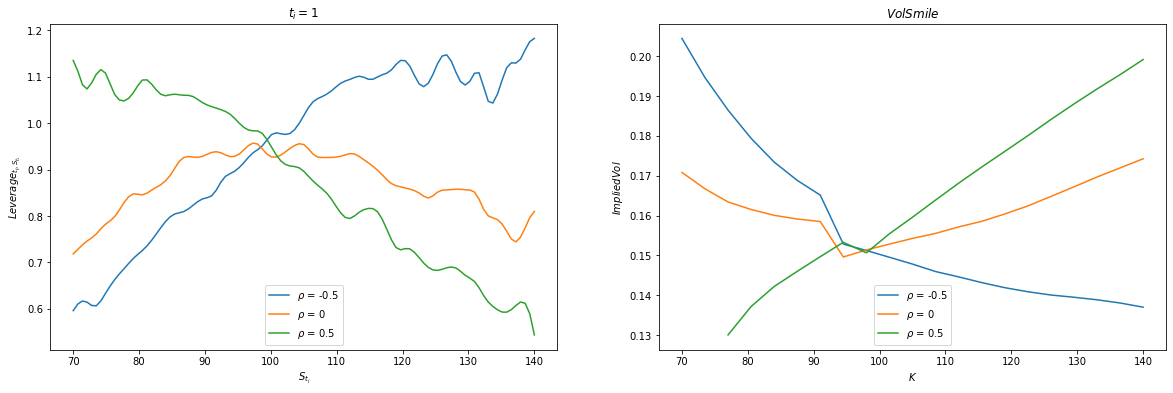

In [419]:
gamma = 0.5
kappa = 1
rho_values = [-0.5,0,0.5]
spot_values = np.linspace(70,140,101)
fig, ax = plt.subplots(1,2,figsize=(20, 6))

for rho in rho_values :
    fits,S = generate_paths(gamma=gamma,kappa=kappa,rho=rho) 
    ax[0].plot(spot_values, fits[-1](spot_values), label= r'$\rho$ = '+str(rho))

ax[0].set_xlabel('$S_{t_{i}}$')
ax[0].set_ylabel('$Leverage_{t_{i},S_{t_{i}}}$')
ax[0].set_title('$t_{i}=1$')
ax[0].legend(loc=0)

for rho in rho_values :
    fits,S = generate_paths(localVol_present=False,gamma=gamma,kappa=kappa,rho=rho) 
    impVol = []
    strikes = np.linspace(70,140,21) 
    for K in strikes :
        payoff_fn = np.vectorize(lambda x : max(x-K,0))
        C = (np.mean(payoff_fn(S[-1])))
        impVol.append(blackscholes_impv(K, T=1, S=100, value=C, callput='call'))
    ax[1].plot(strikes,impVol,label= r'$\rho$ = '+str(rho))

ax[1].set_xlabel('$K$')
ax[1].set_ylabel('$Implied Vol$')
ax[1].set_title('$Vol Smile$')
ax[1].legend(loc=0)


We observe that at ${\rho = 0.5}$ the leverage function is decreasing. 
<br>At ${\rho = 0}$ the leverage function remains at similar levels while achieveing its maximum near strike. 
<br>At ${\rho = -0.5}$ the leverage function is increasing.
<br> This is line with our expectation because if Y and S are positively correlated then with increase in S the leverage function will decrease so that with callibration we get Y such that volatility stays at 0.15.
<br> Implied vol smile is decreasing for negative correlation. Like a smile in case of no correlation and increasing for positive correlation
<br> 

-------------------------------------------------------------------------------------------------------------------------


<b>(d).</b> Fix the spot-vol correlation $\rho = 0\%$ and volatility of volatility $\gamma = 50\%$. We study the impact of mean reversion $\kappa$ on the smile in the pure stochastic volatility model and calibrated leverage function in the SLV model. Perform the following tasks with various values of $\kappa$. Suggested values of $\kappa$: $0.1$, $1$, $10$.
- Recalibrate the leverage function $l(t,S)$ for each $\gamma$, and plot the calibrated leverage function $l(t, S)$ as a function of the spot value $S$ for a fixed maturity, e.g., $t = T$ with various values of $\gamma$ in the same graph. Comment on the dependence of the shape of the leverage function on $\kappa$.
- Plot the corresponding smile at maturity $T$ for the pure stochastic volatility model (set the leverage function $l \equiv 1$) with the various values of $\kappa$ in the same graph. Comment on the dependence of the shape of the smile on $\kappa$.


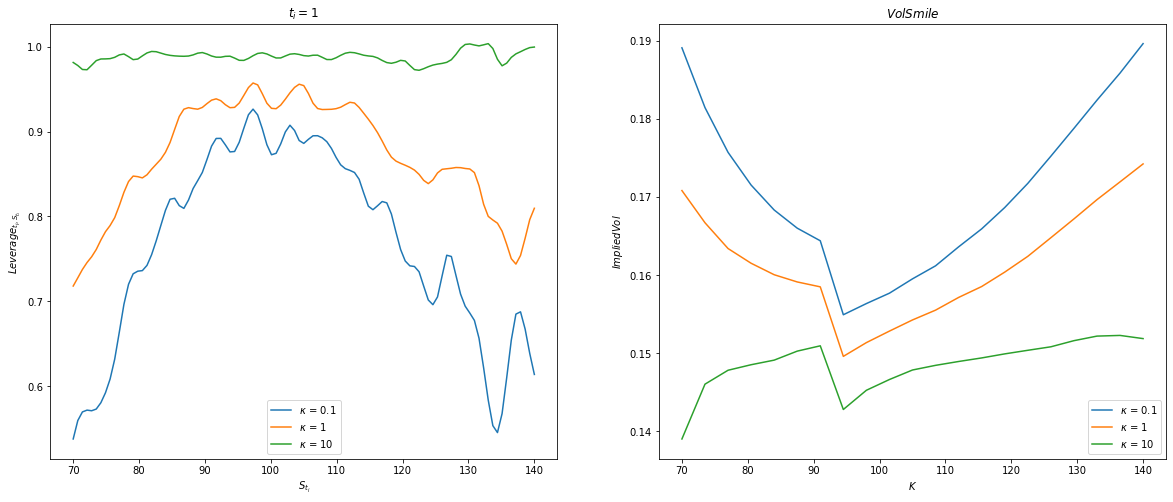

In [44]:
gamma = 0.5
rho = 0
kappa_values = [0.1,1,10]
spot_values = np.linspace(70,140,101)
fig, ax = plt.subplots(1,2,figsize=(20, 8))

for kappa in kappa_values :
    fits,S = generate_paths(gamma=gamma,kappa=kappa,rho=rho) 
    ax[0].plot(spot_values, fits[-1](spot_values), label='$\kappa$ = '+str(kappa))

ax[0].set_xlabel('$S_{t_{i}}$')
ax[0].set_ylabel('$Leverage_{t_{i},S_{t_{i}}}$')
ax[0].set_title('$t_{i}=1$')
ax[0].legend(loc=0)

for kappa in kappa_values :
    fits,S = generate_paths(localVol_present=False,gamma=gamma,kappa=kappa,rho=rho) 
    impVol = []
    strikes = np.linspace(70,140,21) 
    for K in strikes :
        payoff_fn = np.vectorize(lambda x : max(x-K,0))
        C = (np.mean(payoff_fn(S[-1])))
        impVol.append(blackscholes_impv(K, T=1, S=100, value=C, callput='call'))
    ax[1].plot(strikes,impVol,label='$\kappa$ = '+str(kappa))

ax[1].set_xlabel('$K$')
ax[1].set_ylabel('$Implied Vol$')
ax[1].set_title('$Vol Smile$')
ax[1].legend(loc=0)


We observe that as ${\kappa}$ increases the leverage function increases and the implied volatility smile decreases.
When ${\kappa}$ increases ${Y_{t_i}}$ moves faster towards 0 and has lower variance given ${Y_{t_{i-1}}}$. This effect will then be reflected in ${a_t}$ and to counter this leverage function needs to increase and variance of leverage function will reduce to stay calibrated to market volatility. While we observe higher variance in leverage function and lower leverage function for lower values of ${\kappa}$. Lower leverage function entails higher implied vol so as to remain calibrated whicch can bee seen in the implied vol graph.

-------------------------------------------------------------------------------------------------------------------------

<b>(e).</b> Consider the forward-starting straddle with payoff
\begin{equation*}
\left\vert \frac{S_{T_2}}{S_{T_1}}-1 \right\vert
\end{equation*}
with $T_1 = T - \frac{3}{12}$, $T_2 = T$. Use $\gamma = 100\%$, $\rho = -50\%$ and $\kappa=1$. Compare the prices of this option in the Black-Scholes model with volatility 15% and in the calibrated SLV model. Comment on the result. Why is it of interest to use stochastic local volatility models for pricing derivatives?

In [414]:
### Pricing the forward-starting straddle with SLV Model ####
kappa = 1
gamma = 1
rho = -0.5
ts = np.linspace(0,1,101)
t1_idx = np.where(ts== 1-0.25)[0][0]

fits,S = generate_paths(gamma=gamma,kappa=kappa,rho=rho,ts=ts)
payoff = np.abs( (S[-1]/S[t1_idx])-1 )
price = np.mean(payoff)
print('Price of the forward-starting straddle in SLV Model: ',price)

### Pricing the farward-starting straddle with Black-Scholes Model ###
np.random.seed(10)
paths = blackscholes_mc(vol=0.15,ts=ts,npaths=100000)

payoff = np.abs( (paths[-1]/paths[t1_idx])-1 )
price = np.mean(payoff)
print('Price of the forward-starting straddle in Black-Scholes Model: ',price)

Price of the forward-starting straddle in SLV Model:  0.055366921573371405
Price of the forward-starting straddle in Black-Scholes Model:  0.05987997823333386


It is expected that SLV gives a different price from Black-Scholes. The forward start option creates an exposure to the “forward smile risk”, which is associated with the uncertainty of the smile observed in the future. The SLV and Black-Scholes generate the same vanilla smiles at time zero., but not in the future. Thus we observe different prices for the two.